# Cartpole Solution with Deep Q-Learning

This program runs three DQN agents on OpenAI Gym's Cartpole environment. Each agent pertains to a different configuration outlined in the report.

### Setup

First, we import all the necessary libraries that will be used in the program. We use torch for neural network operations, numpy for array manipulation e.g. replay memory, and gym to initialise and step through the environment. In built modules such as random are used in the epsilon greedy strategy to determine whether the agent takes an exploration or exploitation action.

In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import math
import gym
import random

### Network Architecture

We initialise a Deep Q-Network that takes in the current state of the environment, and returns a q-value for each possible action. Across all agent configurations we used the ReLU activation function.

In [2]:
class DQN(nn.Module):
    def __init__(self, learning_rate, inputs, outputs):
        super(DQN, self).__init__()
        self.inputs = inputs
        self.outputs = outputs
        
        self.fc1 = nn.Linear(*self.inputs, 64) #Inputs for Carpole = Observation space = 4
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, self.outputs) #Outputs = Action space = 2
        
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.loss = nn.MSELoss()
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x) #Return raw representation of actions
        
        return actions
        

### Agent Initialisation

This code block represents the structure of the Agent. In this class we:
- Initialise the network, hyperparameters, and replay memory
- Have the choose_action() function which determines whether to take a random or greedy action depending on the value of epsilon.
- Store the experience of the agent after every timestep in store_transition()
- Have the batch_tensor() function which converts the batch of experiences to a tensor to be passed into the network.
- Have the epsilon_decay() function which decays the value of Epsilon every time the agent learns.
- Have the learn() function which optimises the agent.

In [3]:
class Agent():
    def __init__(self, discount, epsilon, learning_rate, inputs, batch_size, outputs, min_eps, decay, replay_mem_size):
        self.discount = discount                             #Discount factor
        self.epsilon = epsilon                               #Controls the exploration/exploitation rate of actions
        self.min_eps = min_eps                               #Minimum value to shrink epsilon
        self.decay = decay                                   #Controls how quickly epsilon decays
        self.learning_rate = learning_rate                   #Controls the step size towards the optimum weights
        self.action_space = [i for i in range(outputs)]      #Stores possible actions into an array
        self.replay_mem_size = replay_mem_size               #Size of the experience replay the agent learns from
        self.batch_size = batch_size                         #The size of the batch taken from experience replay to be passed into the network during learning
        self.mem_index = 0                                   #Keeps track of the size of memory

        self.Q_network = DQN(self.learning_rate, inputs=inputs, outputs=outputs) #Initialise DQN
    
        #Store current state, next state, action taken and reward for learning
        self.state_memory = np.zeros((self.replay_mem_size, *inputs), dtype=np.float32)
        self.new_state_memory = np.zeros((self.replay_mem_size, *inputs), dtype=np.float32)
        self.action_memory = np.zeros(self.replay_mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.replay_mem_size, dtype=np.float32)

        self.losses = []

    #Stores agent experience each timestep
    def store_transition(self, state, action, reward, next_state):
        index = self.mem_index % self.replay_mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = next_state
        self.action_memory[index] = action
        self.reward_memory[index] = reward

        self.mem_index += 1

    #Determines whether to take a random or informed action
    def choose_action(self, observation):
        if np.random.random() > self.epsilon: #Select greedy (best) action
            state = T.tensor([observation]) #Convert to tensor before passing into network
            actions = self.Q_network.forward(state)
            action = T.argmax(actions).item() #Take the action with the highest q-value
        else: #Select random action
            action = np.random.choice(self.action_space)

        return action

    #Converts the batch to tensors prior to passing into network
    def batch_tensor(self, batch):
        state_batch = T.tensor(self.state_memory[batch])
        new_state_batch = T.tensor(self.new_state_memory[batch])
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(self.reward_memory[batch])
        
        return state_batch, new_state_batch, action_batch, reward_batch
    
    #Decays the value of epsilon controlled by a decay rate parameter
    def epsilon_decay(self):
        if (self.epsilon > self.min_eps):
            self.epsilon = self.epsilon * self.decay
        else:
            self.epsilon = self.min_eps
    
    #Agent optimisation process
    def learn(self):
        if self.mem_index < self.batch_size: #Wait till replay memory is at least the same size as the batch before learning
            return

        self.Q_network.optimizer.zero_grad() #With PyTorch, optimiser gradient must be rest first

        max_replay_mem = min(self.mem_index, self.replay_mem_size) #Get max memory size
        batch = np.random.choice(max_replay_mem, self.batch_size, replace=False) #Select batch from memory

        batch_index = np.arange(self.batch_size, dtype=np.int32)
    
        state_batch, new_state_batch, action_batch, reward_batch = self.batch_tensor(batch) #Convert batch values to Pytorch tensor

        q_current = self.Q_network.forward(state_batch)[batch_index, action_batch] #Current state
        q_next = self.Q_network.forward(new_state_batch) #Next state estimate

        q_target = reward_batch + self.discount*T.max(q_next,dim=1)[0] #Return maximum q value for next state

        loss = self.Q_network.loss(q_target, q_current) #Calculate loss
        self.losses.append(loss.item())
        loss.backward()
        self.Q_network.optimizer.step()
        
        #Update epsilon
        self.epsilon_decay()

### Setup

In this code block we define the hyperparameter values and initialise the agents and environment. In this file we have included the agents from all three configurations outlined in the report. 

In [4]:
#Goal: To reach an average reward of 195 over 100 episodes

env = gym.make('CartPole-v1')
episodes = 101

agentConfig1 = Agent(discount=0.99, epsilon=0.999, batch_size=64, outputs=2, min_eps=0.05, inputs=[4], learning_rate=0.005, decay=0.99, replay_mem_size=500)
agentConfig2 = Agent(discount=0.99, epsilon=0.999, batch_size=128, outputs=2, min_eps=0.05, inputs=[4], learning_rate=0.001, decay=0.999, replay_mem_size=1000)
agentOptimal = Agent(discount=1.0, epsilon=0.999, batch_size=128, outputs=2, min_eps=0.05, inputs=[4], learning_rate=0.001, decay=0.999, replay_mem_size=1000)

### Main Loop

To analyse a specific agent's performance, simply comment out either Line 27 or Line 29, or Line 31 of this code block depending on the desired agent to be run. We also define the main loop of the agent which:
- Selects an action to take in the environment
- Executes the action
- Adds the reward gained to the total running score of the episode
- Stores the experience
- Updates the agent as long as if the replay memory size is at least as big as the batch size
- Logs the reward of the agent every 5 episodes to track learning

This process is repeated for each episode that the agent runs for (and will run for each agent initialised).

In [5]:
def rollout(agent):
    scores, eps_history = [], []
    for i in range(episodes):
        score = 0
        done = False
        observation = env.reset()
        while not done:
            action = agent.choose_action(observation.astype(np.float32))
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.store_transition(observation, action, reward, observation_)
            agent.learn()
            observation = observation_

        scores.append(score)
        eps_history.append(agent.epsilon)

        if(i % 5 == 0 or i == 99):
            print("Episode: ", i, "Score: ",
            '%.2f' % score, "Epsilon: ",
            '%.2f' % agent.epsilon)
    
    return scores, eps_history

print("Running Agent 1")  
ag1Score, ag1Eps = rollout(agentConfig1)
print("Running Agent 2")  
ag2Score, ag2Eps = rollout(agentConfig2)
print("Running Agent 3")  
agScore, agEps = rollout(agentOptimal)

Running Agent 1
Episode:  0 Score:  19.00 Epsilon:  1.00
Episode:  5 Score:  24.00 Epsilon:  0.26
Episode:  10 Score:  131.00 Epsilon:  0.05
Episode:  15 Score:  103.00 Epsilon:  0.05
Episode:  20 Score:  291.00 Epsilon:  0.05
Episode:  25 Score:  33.00 Epsilon:  0.05
Episode:  30 Score:  9.00 Epsilon:  0.05
Episode:  35 Score:  10.00 Epsilon:  0.05
Episode:  40 Score:  10.00 Epsilon:  0.05
Episode:  45 Score:  9.00 Epsilon:  0.05
Episode:  50 Score:  10.00 Epsilon:  0.05
Episode:  55 Score:  9.00 Epsilon:  0.05
Episode:  60 Score:  9.00 Epsilon:  0.05
Episode:  65 Score:  12.00 Epsilon:  0.05
Episode:  70 Score:  10.00 Epsilon:  0.05
Episode:  75 Score:  11.00 Epsilon:  0.05
Episode:  80 Score:  9.00 Epsilon:  0.05
Episode:  85 Score:  10.00 Epsilon:  0.05
Episode:  90 Score:  10.00 Epsilon:  0.05
Episode:  95 Score:  10.00 Epsilon:  0.05
Episode:  99 Score:  9.00 Epsilon:  0.05
Episode:  100 Score:  9.00 Epsilon:  0.05
Running Agent 2
Episode:  0 Score:  20.00 Epsilon:  1.00
Episode:

In [6]:
import matplotlib.pyplot as plt

### Configuration 1 Results

Plotting:
- Episode against total reward
- Epsilon decay over time

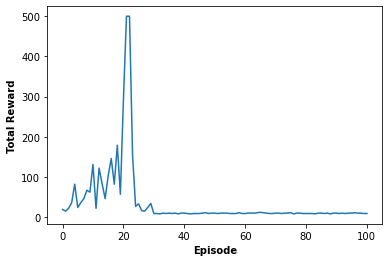

In [7]:
plt.plot(ag1Score, label="Configuration 1")
plt.xlabel("Episode", fontweight="bold")
plt.ylabel("Total Reward", fontweight="bold")
plt.show()

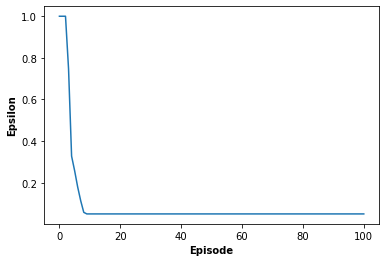

In [8]:
plt.plot(ag1Eps, label="Configuration 1")
plt.xlabel("Episode", fontweight="bold")
plt.ylabel("Epsilon", fontweight="bold")
plt.show()

### Configuration 2 Results

Plotting:
- Episode against total reward
- Epsilon decay over time

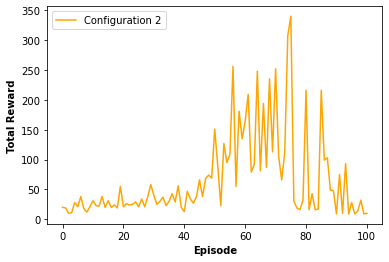

In [15]:
plt.plot(ag2Score, label="Configuration 2", color="orange")
plt.xlabel("Episode", fontweight="bold")
plt.ylabel("Total Reward", fontweight="bold")
plt.legend()
plt.show()

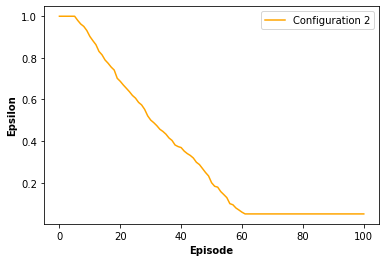

In [16]:
plt.plot(ag2Eps, label="Configuration 2", color="orange")
plt.xlabel("Episode", fontweight="bold")
plt.ylabel("Epsilon", fontweight="bold")
plt.legend()
plt.show()

### Configuration 3 Results

Plotting:
- Episode against total reward
- Epsilon decay over time

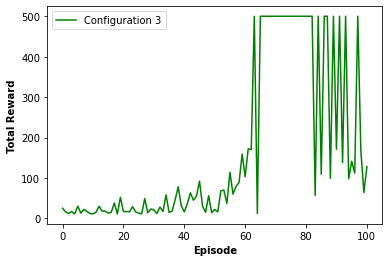

In [17]:
plt.plot(agScore, label="Configuration 3", color="green")
plt.xlabel("Episode", fontweight="bold")
plt.ylabel("Total Reward", fontweight="bold")
plt.legend()
plt.show()

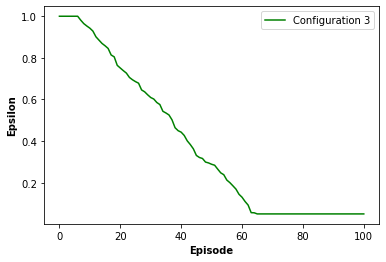

In [18]:
plt.plot(agEps, label="Configuration 3", color="green")
plt.xlabel("Episode", fontweight="bold")
plt.ylabel("Epsilon", fontweight="bold")
plt.legend()
plt.show()

### Configurations Compared

Plot the three configurations against eachother for analysis in the report attached

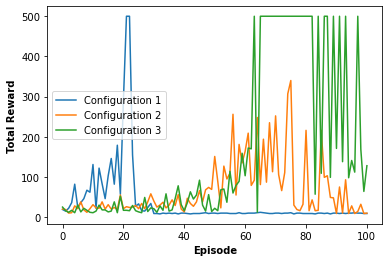

In [13]:
plt.plot(ag1Score, label="Configuration 1")
plt.plot(ag2Score, label="Configuration 2")
plt.plot(agScore, label="Configuration 3")
plt.xlabel("Episode", fontweight="bold")
plt.ylabel("Total Reward", fontweight="bold")
plt.legend()
plt.show()

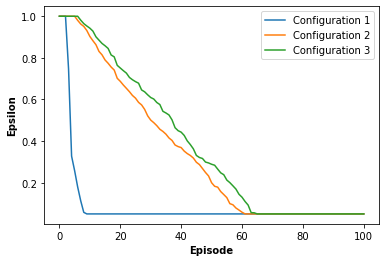

In [14]:
plt.plot(ag1Eps, label="Configuration 1")
plt.plot(ag2Eps, label="Configuration 2")
plt.plot(agEps, label="Configuration 3")
plt.xlabel("Episode", fontweight="bold")
plt.ylabel("Epsilon", fontweight="bold")
plt.legend()
plt.show()